In [9]:
import numpy as np
import scipy
import scipy.stats
import nibabel as nib
from nilearn import surface
from nilearn import plotting
import pandas as pd
import glob
import os
import pdb
from multiprocessing import Process, Manager
%matplotlib inline

import matplotlib.pyplot as plt
import ipyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from scipy.stats import pearsonr, zscore

In [17]:
#List of patients
fp='factorizations/20210621-Adrienne/'
eids=pd.read_csv(fp+"participants.txt", sep=" ")

#Load factors from Ka Chun
eid_order=pd.read_csv(fp+'HBN_20210621.csv')
factors=np.load(fp+'factorizations/HBN_20210714-k12b1-Wbdd.npz')
W=factors['W']
C=factors['C']

#Make individual training datasets (in case some patients don't have data for all three measures)
X_curv_L, X_sulc_L, X_thickness_L, X_curv_R, X_sulc_R, X_thickness_R = list(), list(), list(), list(), list(), list()
y_curv_L, y_sulc_L, y_thickness_L, y_curv_R, y_sulc_R, y_thickness_R = list(), list(), list(), list(), list(), list()
unfound=list()
for i in range(0,len(eids)):
    eid=eids.iloc[i][0]
    #Is participant in HBN files
    try:
        w_row = eid_order[eid_order['EID'] == eid].index[0]
    except:
        unfound.append(eid)
    #Add to training datasets
    else:
        if os.path.exists('/Datasets/HBN/Surfaces/'+eid+'_lh_curv.npy'):
            X_curv_L.append(np.concatenate((C[w_row,:],W[w_row,:])))
            X_curv_R.append(np.concatenate((C[w_row,:],W[w_row,:])))
            y_curv_L.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_lh_curv.npy'))
            y_curv_R.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_rh_curv.npy'))
        if os.path.exists('/Datasets/HBN/Surfaces/'+eid+'_lh_sulc.npy'):
            X_sulc_L.append(np.concatenate((C[w_row,:],W[w_row,:])))
            X_sulc_R.append(np.concatenate((C[w_row,:],W[w_row,:])))
            y_sulc_L.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_lh_sulc.npy'))
            y_sulc_R.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_rh_sulc.npy'))
        if os.path.exists('/Datasets/HBN/Surfaces/'+eid+'_lh_thickness.npy'):
            X_thickness_L.append(np.concatenate((C[w_row,:],W[w_row,:])))
            X_thickness_R.append(np.concatenate((C[w_row,:],W[w_row,:])))
            y_thickness_L.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_lh_thickness.npy'))
            y_thickness_R.append(np.load('/Datasets/HBN/Surfaces/'+eid+'_rh_thickness.npy'))
X_curv_L=np.asarray(X_curv_L)
X_curv_R=np.asarray(X_curv_R)

#Changed from scaling meshes from 0 to 1 (scaler) to z scoring
#scaler=MinMaxScaler()
y_curv_L=np.asarray(y_curv_L)
y_curv_L=np.nan_to_num(zscore(y_curv_L, axis=0))
#y_curv_L=scaler.fit_transform(y_curv_L)
y_curv_R=np.asarray(y_curv_R)
#y_curv_R=scaler.fit_transform(y_curv_R)
y_curv_R=np.nan_to_num(zscore(y_curv_R, axis=0))

X_sulc_L=np.asarray(X_sulc_L)
X_sulc_R=np.asarray(X_sulc_R)

y_sulc_L=np.asarray(y_sulc_L)
y_sulc_L=np.nan_to_num(zscore(y_sulc_L, axis=0))
#y_sulc_L=scaler.fit_transform(y_sulc_L)
y_sulc_R=np.asarray(y_sulc_R)
y_sulc_R=np.nan_to_num(zscore(y_sulc_R, axis=0))
#y_sulc_R=scaler.fit_transform(y_sulc_R)

X_thickness_L=np.asarray(X_thickness_L)
X_thickness_R=np.asarray(X_thickness_R)

y_thickness_L=np.asarray(y_thickness_L)
y_thickness_L=np.nan_to_num(zscore(y_thickness_L, axis=0))
#y_thickness_L=scaler.fit_transform(y_thickness_L)
y_thickness_R=np.asarray(y_thickness_R)
y_thickness_R=np.nan_to_num(zscore(y_thickness_R, axis=0))
#y_thickness_R=scaler.fit_transform(y_thickness_R)


In [20]:
def gen_plot(data,vmin,vmax,right=False,static=False):
    if right:
        geometry_pial = '/Datasets/templateflow/tpl-fsaverage/tpl-fsaverage_hemi-R_den-164k_pial.surf.gii'
    else:
        geometry_pial = '/Datasets/templateflow/tpl-fsaverage/tpl-fsaverage_hemi-L_den-164k_pial.surf.gii'
    if static:
        view_b_grads_0 = plotting.plot_surf(geometry_pial,data,symmetric_cmap=False,cmap='seismic',vmin=vmin, vmax=vmax, colorbar=True)
    else:
        view_b_grads_0 = plotting.view_surf(geometry_pial,data,symmetric_cmap=False,cmap='seismic',vmin=vmin, vmax=vmax, colorbar=True)
    return view_b_grads_0

def feature_plots(model, name, vmin, vmax, right=False, static=False):
    coeffs = model.coef_
    coeffs = coeffs/np.absolute(coeffs).max()
    for i in range(0,coeffs.shape[1]):
        fig=gen_plot(coeffs[:,i].T,vmin,vmax,right=right,static=static)
        if static:
            fig.savefig('k'+str(coeffs.shape[1]-2)+'_results/static_images/features/'+name+str(i+1)+'.png', bbox_inches='tight')#pad_inches=0.2)
        else:
            fig.save_as_html('k'+str(coeffs.shape[1]-2)+'_results/figures/features/'+name+str(i+1)+'.html')

Thickness_R 1000.0 0.004166898575026374


/home/kinneyac/miniconda3/envs/ak/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


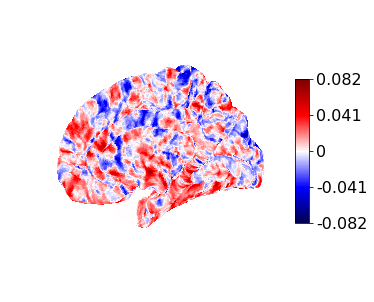

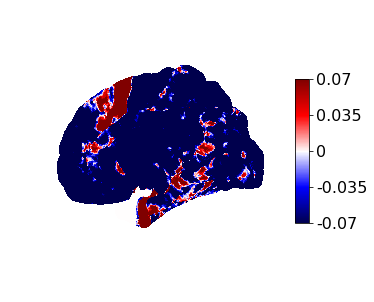

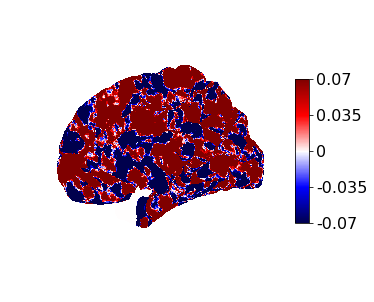

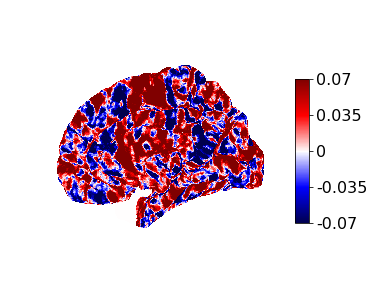

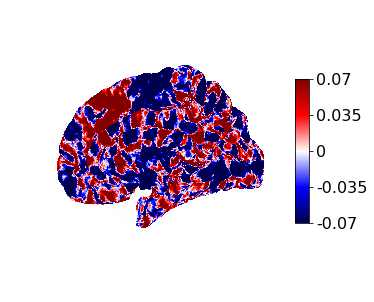

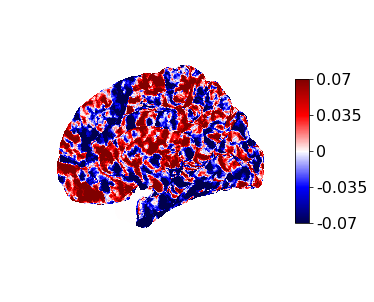

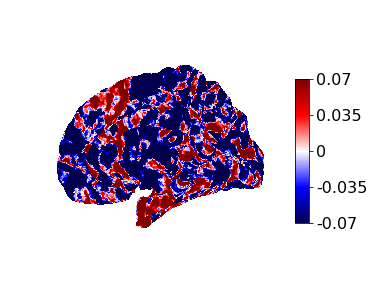

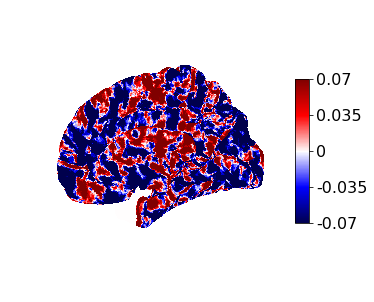

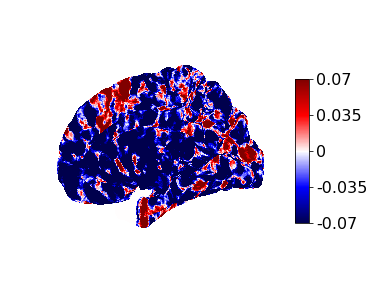

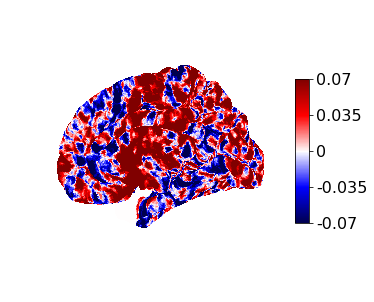

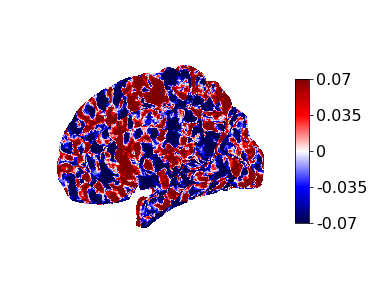

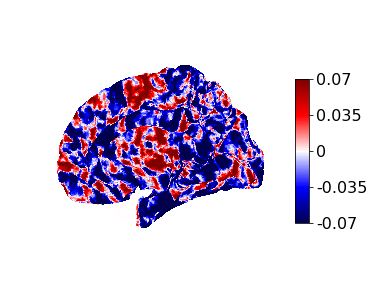

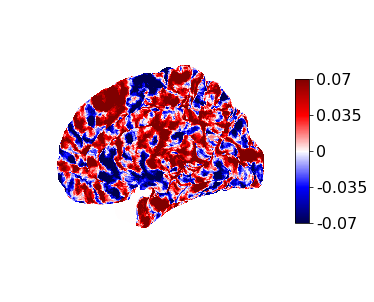

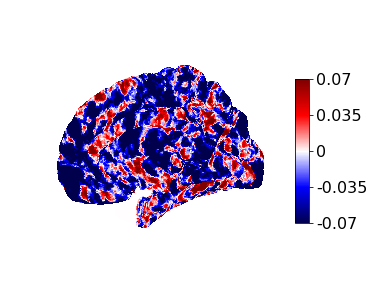

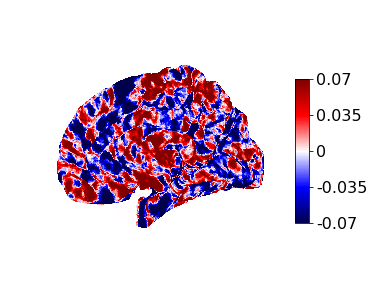

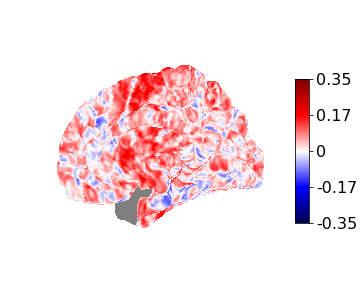

In [29]:
from sklearn.model_selection import KFold

#Determine the best alpha for each dataset
def find_alphas(X_data, y_data, names):
    alphas_test=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
    alphas=list()
    for i in range(0,len(names)):
        X=X_data[i]
        y=y_data[i]
        name=names[i]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        cv = KFold(n_splits=10)
        ridge_reg = RidgeCV(alphas=alphas_test,cv=cv).fit(X_train, y_train)
        alphas.append(ridge_reg.alpha_)
        print(name+' '+str(ridge_reg.alpha_))
    return alphas

#Ridge regression
X_data=[X_curv_L, X_curv_R, X_sulc_L, X_sulc_R, X_thickness_L, X_thickness_R]
y_data=[y_curv_L, y_curv_R, y_sulc_L, y_sulc_R, y_thickness_L, y_thickness_R]
names=['Curv_L','Curv_R','Sulc_L','Sulc_R','Thickness_L','Thickness_R']

#Get alpha for each dataset
alphas=find_alphas(X_data, y_data, names)

plt.rcParams['font.size'] = 16
#Plot static or dynamic plots (static is good enough for now)
static=True
for i in range(0,len(names)):
    X=X_data[i]
    y=y_data[i]
    name=names[i]
    alpha=alphas[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    ridge_reg = Ridge(alpha=alpha).fit(X_train, y_train)
    #Plot intercepts
    if False:
        fig=plt.figure(i)
        plt.hist(ridge_reg.intercept_,100)
        fig.savefig('k'+str(X.shape[1]-2)+'_results/static_images/'+name+'_hist.png')
    
    #Predict using trained model
    predictions = ridge_reg.predict(X_test)
    
    #What range of values to show
    if False:
        vmin=np.percentile(ridge_reg.coef_.flatten(),.1)
        vmax=np.percentile(ridge_reg.coef_.flatten(),99.9)
    else:
        vmin=(ridge_reg.coef_).min()
        vmax=(ridge_reg.coef_).max()
    
    #Plotting right or left side
    if '_R' in name:
        right=True
    else:
        right=False
    
    #Plot intercepts on mesh
    rang=max(abs(min(ridge_reg.intercept_)), abs(max(ridge_reg.intercept_)))
    fig=gen_plot(ridge_reg.intercept_,-rang,rang,right=right,static=static)
    fig.savefig('k'+str(X.shape[1]-2)+'_results/static_images/'+name+'_intercept.png',bbox_inches='tight')
    
    #Plot feature meshes
    rang = max(abs(vmin), abs(vmax))
    feature_plots(ridge_reg, name, -rang, rang, right=right, static=static)
    
    #Plot correlations
    if True:
        corrs_reg = np.zeros(y_test.shape[1])
        for j in range(0, len(corrs_reg)):
            corrs_reg[j] = pearsonr(predictions[:,j], y_test[:,j])[0]
        rang = max(abs(min(corrs_reg)), abs(max(corrs_reg)))
        fig=gen_plot(corrs_reg,-rang,rang,right=right,static=static)
        if static:
            fig.savefig('k'+str(X.shape[1]-2)+'_results/static_images/vertex_corr/'+name+'.png',bbox_inches='tight')
        else:
            fig.save_as_html('k'+str(X.shape[1]-2)+'_results/figures/vertex_corr/'+name+'_vertex_corr.html')
            

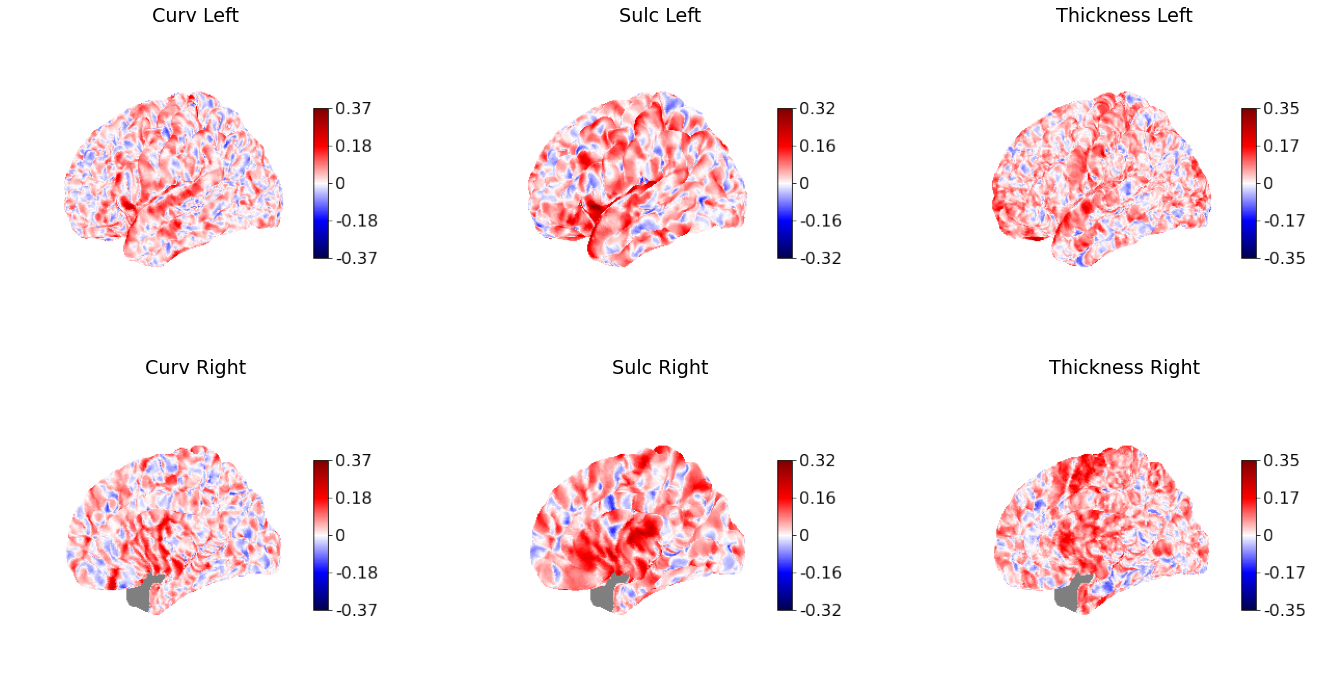

In [30]:
#Combine correlation plots
import matplotlib.image as mpimg
val=12
ddir='k'+str(val)+'_results/static_images/vertex_corr/'
imgs=[ddir+'Curv_L.png',ddir+'Sulc_L.png',ddir+'Thickness_L.png',ddir+'Curv_R.png',ddir+'Sulc_R.png',ddir+'Thickness_R.png']
labels=['Curv Left','Sulc Left','Thickness Left','Curv Right','Sulc Right','Thickness Right']
#ipyplot.plot_class_representations(imgs,labels,img_width=250)
        
nrows=2
ncols=3
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['font.size'] = 16
    
fig = plt.figure()
for i in range(0,len(imgs)):
    img=imgs[i]
    label=labels[i]
    img=mpimg.imread(img)
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
fig.tight_layout()
plt.savefig('k'+str(val)+'_results/k'+str(val)+'_vertex_corr.png')
plt.show()

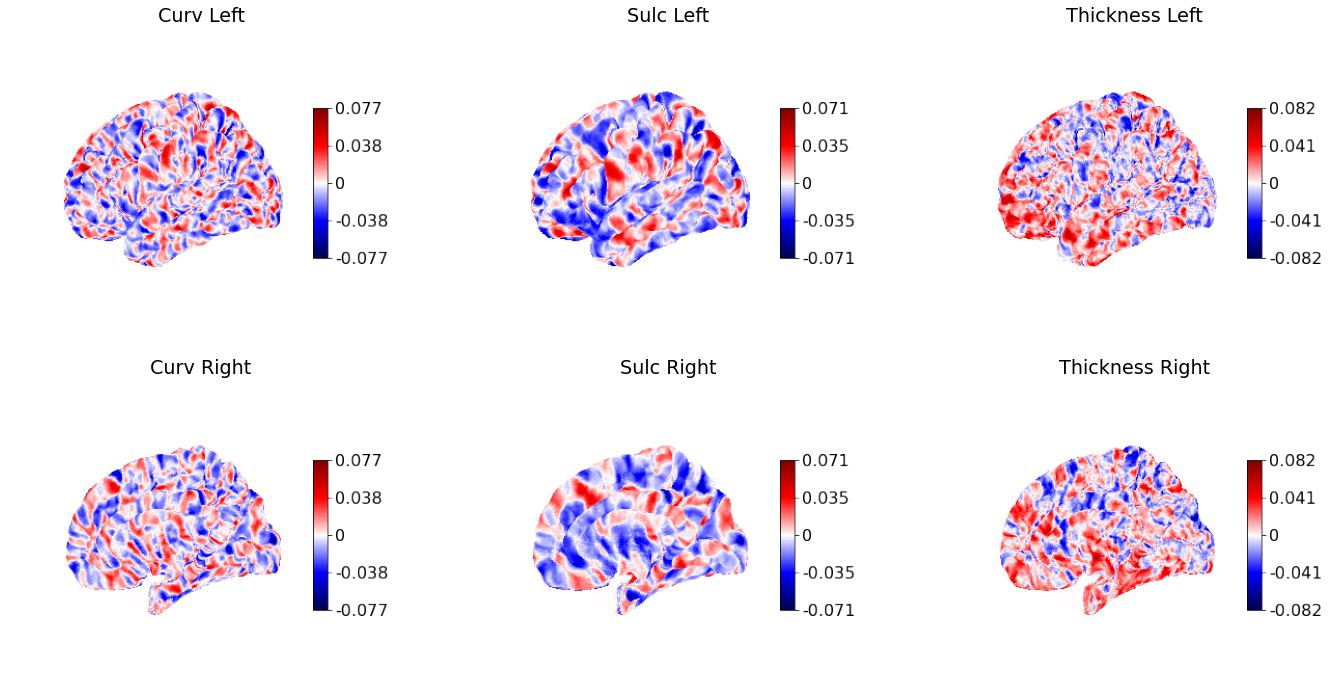

In [32]:
#Combine intercept plots
import matplotlib.image as mpimg
val=12
ddir='k'+str(val)+'_results/static_images/'
imgs=[ddir+'Curv_L_intercept.png',ddir+'Sulc_L_intercept.png',ddir+'Thickness_L_intercept.png',ddir+'Curv_R_intercept.png',ddir+'Sulc_R_intercept.png',ddir+'Thickness_R_intercept.png']
labels=['Curv Left','Sulc Left','Thickness Left','Curv Right','Sulc Right','Thickness Right']
#ipyplot.plot_class_representations(imgs,labels,img_width=250)
        
nrows=2
ncols=3
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['font.size'] = 16
    
fig = plt.figure()
for i in range(0,len(imgs)):
    img=imgs[i]
    label=labels[i]
    img=mpimg.imread(img)
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
fig.tight_layout()
plt.savefig('k'+str(val)+'_results/k'+str(val)+'_intercepts.png')
plt.show()

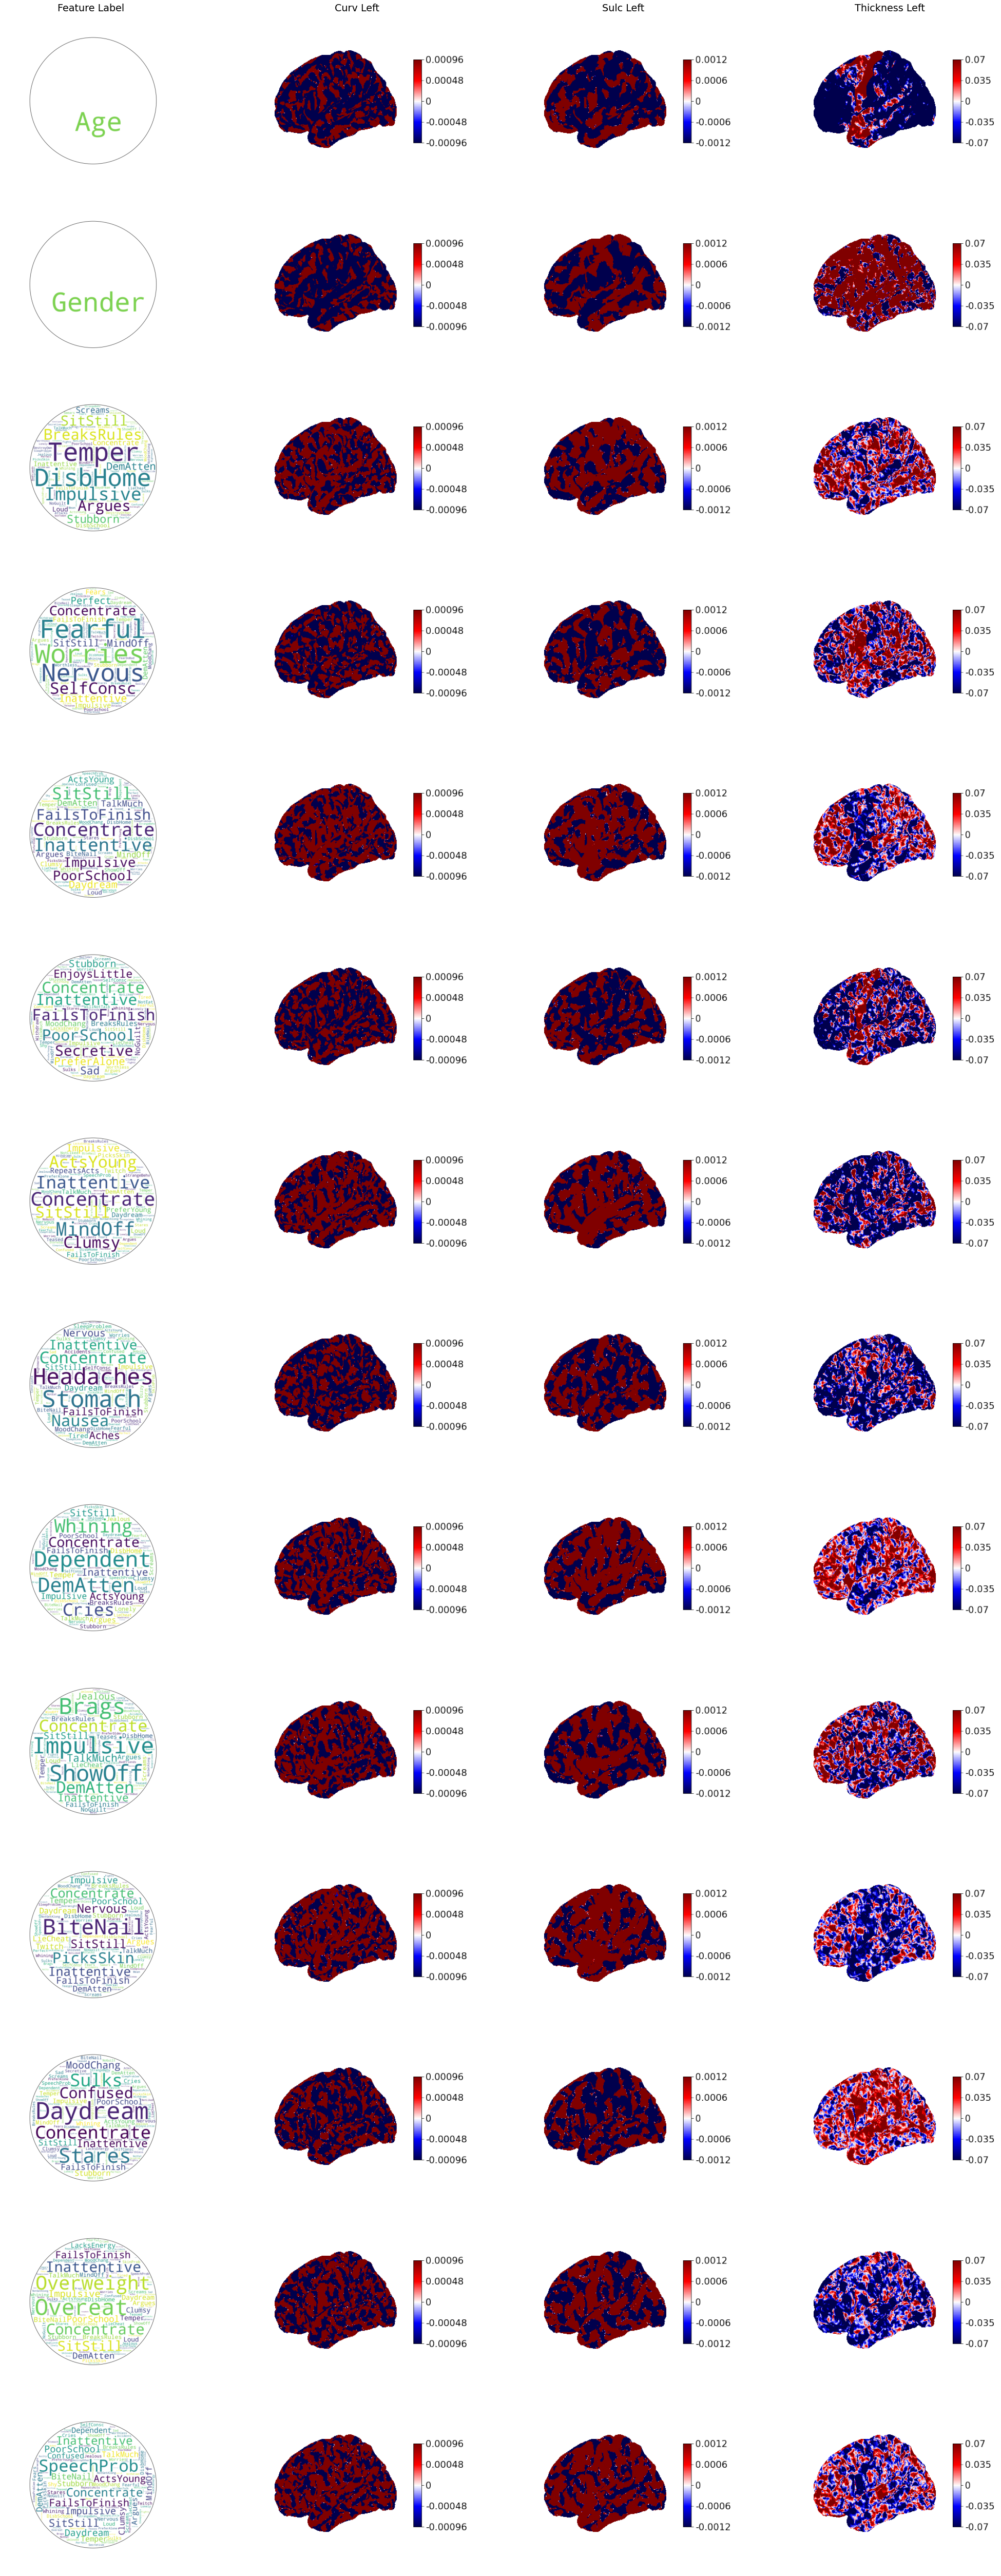

In [34]:
#Combine feature plots
import matplotlib.image as mpimg
val=12
hemi='L'
if hemi=='R':
    left_right='Right'
else:
    left_right='Left'
ddir='k'+str(val)+'_results/static_images/features/'
measures=['Curv_'+hemi,'Sulc_'+hemi,'Thickness_'+hemi]
features=np.arange(1,val+3)
imgs=list()
labels=list()
for feature in features:
    labels.append('Feature Label')
    imgs.append('k'+str(val)+'_results/static_images/feature_labels/group'+str(feature)+'.png')
    for measure in measures:
        imgs.append(ddir+measure+str(feature)+'.png')
        labels.append(measure.replace('_'+hemi,' '+left_right))

nrows=len(features)
ncols=len(measures)+1
plt.rcParams['figure.figsize'] = [30,70]
plt.rcParams['font.size'] = 16

fig = plt.figure()
for i in range(0,len(imgs)):
    img=imgs[i]
    label=labels[i]
    img=mpimg.imread(img)
    fig.add_subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    if i<4:
        plt.title(label)
plt.tight_layout()
plt.savefig('k'+str(val)+'_results/k'+str(val)+'_feature_maps_'+hemi+'.png')
plt.show()


In [ ]:
#Ordinary least squares linear regression
X_data=[X_curv_L, X_curv_R, X_sulc_L, X_sulc_R, X_thickness_L, X_thickness_R]
y_data=[y_curv_L, y_curv_R, y_sulc_L, y_sulc_R, y_thickness_L, y_thickness_R]
names=['Curv_L','Curv_R','Sulc_L','Sulc_R','Thickness_L','Thickness_R']
print(y_curv_L.max())
print(y_curv_L.min())

static=True
for i in range(0,len(names)):
    X=X_data[i]
    y=y_data[i]
    name=names[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    predictions = reg.predict(X_test)

    if True:
        vmin=np.percentile(reg.coef_.flatten(),5)
        vmax=np.percentile(reg.coef_.flatten(),95)
    else:
        vmin=(reg.coef_).min()
        vmax=(reg.coef_).max()
    if '_R' in name:
        right=True
    else:
        right=False
    feature_plots(reg, name, vmin, vmax, right=right, static=static)
    if True:
        corrs_reg = np.zeros(y_test.shape[1])
        for j in range(0, len(corrs_reg)):
            corrs_reg[j] = pearsonr(predictions[:,j], y_test[:,j])[0]
        fig=gen_plot(corrs_reg,min(corrs_reg),max(corrs_reg),right=right,static=static)
        if static:
            fig.savefig('k6_results/static_images/vertex_r2/'+name+'.png',bbox_inches='tight')
        else:
            fig.save_as_html('k6_results/figures/vertex_r2/'+name+'_vertex_r2.html')
            
            print(y_curv_L.max())